In [3]:
# import nltk
# nltk.download_shell()
# download 'stopwords'

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import string
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

plt.style.use('dark_background')

%matplotlib inline

In [5]:
messages = [line.rstrip() for line in open('./data/smsspamcollection/SMSSpamCollection')]
print(len(messages))

5574


In [6]:
for message_no, message in enumerate(messages[:10]):
    print(message_no, message)
    print('\n')

0 ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...


1 ham	Ok lar... Joking wif u oni...


2 spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's


3 ham	U dun say so early hor... U c already then say...


4 ham	Nah I don't think he goes to usf, he lives around here though


5 spam	FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv


6 ham	Even my brother is not like to speak with me. They treat me like aids patent.


7 ham	As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune


8 spam	WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code 

In [7]:
messages = pd.read_csv('./data/smsspamcollection/SMSSpamCollection', sep='\t', names=["label", "message"])
messages.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [8]:
messages.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [9]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [10]:
messages.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

In [11]:
messages['length'] = messages['message'].apply(len)
messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


<Axes: ylabel='Frequency'>

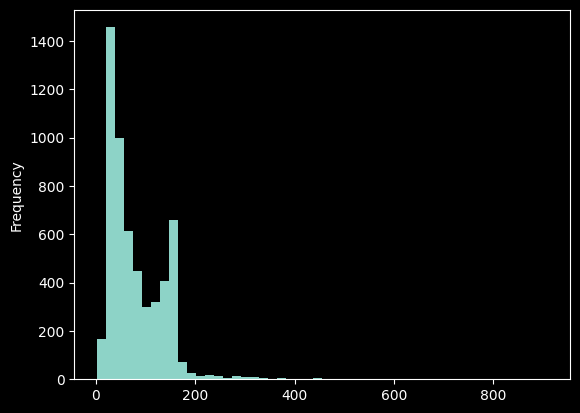

In [12]:
messages['length'].plot(bins=50, kind='hist') 

In [13]:
messages.length.describe()

count    5572.000000
mean       80.489950
std        59.942907
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: length, dtype: float64

array([<Axes: title={'center': 'ham'}>, <Axes: title={'center': 'spam'}>],
      dtype=object)

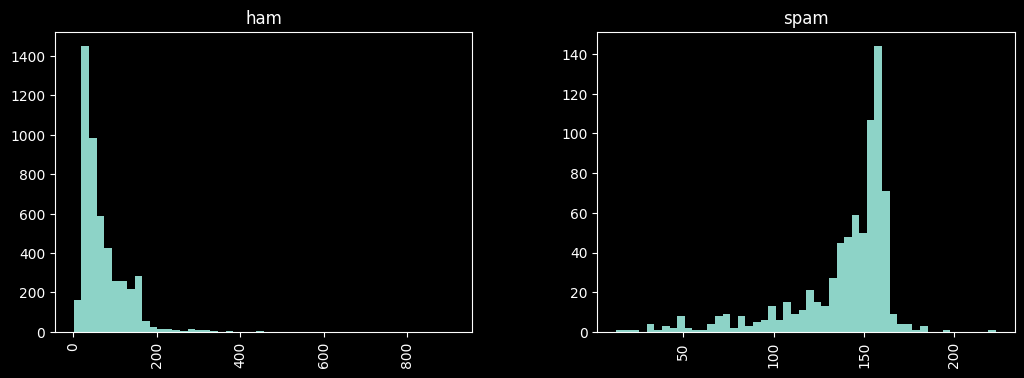

In [14]:
messages.hist(column='length', by='label', bins=50, figsize=(12,4))

In [15]:
def text_process(raw_data):

    """
    1. remove punctuation
    2. remove stopwords
    3. return list of clean text words

    """

    no_punc = [char for char in raw_data if char not in string.punctuation]
    no_punc = ''.join(no_punc)

    return [word for word in no_punc.split() if word.lower() not in stopwords.words('english')]

In [16]:
messages['message'].head(5).apply(text_process)

0    [Go, jurong, point, crazy, Available, bugis, n...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, 2, wkly, comp, win, FA, Cup, fin...
3        [U, dun, say, early, hor, U, c, already, say]
4    [Nah, dont, think, goes, usf, lives, around, t...
Name: message, dtype: object

In [19]:
bow_tranformer = CountVectorizer(analyzer=text_process).fit(messages['message'])
print(len(bow_tranformer.vocabulary_))

11425


In [21]:
messages_bow = bow_tranformer.transform(messages['message'])
print(f"Shape of sparse matrix: {messages_bow.shape}")
print(f"No. of non-zero occurences: {messages_bow.nnz}")

Shape of sparse matrix: (5572, 11425)
No. of non-zero occurences: 50548


In [24]:
tf_idf = TfidfTransformer().fit(messages_bow)
messages_tf_idf = tf_idf.transform(messages_bow)

In [26]:
spam_detect_model = MultinomialNB().fit(messages_tf_idf, messages['label'])
predictions = spam_detect_model.predict(messages_tf_idf)

In [28]:
msg_train, msg_test, label_train, label_test = train_test_split(messages['message'], messages['label'], test_size=0.3)

In [29]:
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),
    ('tfidf', TfidfTransformer()),
    ('classifier', MultinomialNB())
])

In [30]:
pipeline.fit(msg_train, label_train)
predictions = pipeline.predict(msg_test)

print(f"Classification Report:\n{classification_report(label_test, predictions)}\n")
print(f"Confusion Matrix:\n{confusion_matrix(label_test, predictions)}")

Classification Report:
              precision    recall  f1-score   support

         ham       0.96      1.00      0.98      1461
        spam       1.00      0.74      0.85       211

    accuracy                           0.97      1672
   macro avg       0.98      0.87      0.92      1672
weighted avg       0.97      0.97      0.97      1672


Confusion Matrix:
[[1461    0]
 [  54  157]]
